In [1]:
# Standard Libraries
import os # operating system dependent functionality
from collections import Counter # counting elements in an iterable

# External Libraries
import numpy as np # numerical operations on data arrays and matrices
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # plotting and visualizations
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# Bioinformatics and Data Analysis 
import anndata # handling annotated data, particularly in genomics
import scanpy as sc # single-cell RNA-seq data analysis
import scipy # scientific and technical computations

# Confusion Matrix visualization
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import seaborn as sns

In [2]:
import ot 

# Load human and mouse processed and homolog intersected data

In [3]:
# load processed AnnData objects for human and mouse cells
human_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/human_pancreas_preprocessed_log10_homolog_intersected_adata.h5ad")
mouse_restricted = anndata.read_h5ad("/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_data/mouse_pancreas_preprocessed_log10_homolog_intersected_adata.h5ad")

In [39]:
human_restricted.n_obs

8569

In [4]:
# Ensure organism key is present for both human and mouse
if 'organism' not in human_restricted.obs:
    human_restricted.obs['organism'] = 'Homo sapiens'
if 'organism' not in mouse_restricted.obs:
    mouse_restricted.obs['organism'] = 'Mus musculus'

# Ensure cell_tyope key is present - slightly misworded
if 'cell_type' not in human_restricted.obs:
    human_restricted.obs['cell_type'] = human_restricted.obs['cell_types']
if 'cell_type' not in mouse_restricted.obs:
    mouse_restricted.obs['cell_type'] = mouse_restricted.obs['cell_types']

human_restricted.obs['cell_type'] = [x.lower() for x in human_restricted.obs['cell_type']]
mouse_restricted.obs['cell_type'] = [x.lower() for x in mouse_restricted.obs['cell_type']]

# Add species labels
human_restricted.obs['species'] = 'human'
mouse_restricted.obs['species'] = 'mouse'

In [7]:
def optimal_transport_pairing(combined_adata):
    """
    Compute the optimal transport (OT) pairing between human and mouse cells using a combined AnnData object.
    
    Parameters:
    - combined_adata: AnnData object containing concatenated human and mouse data
                     (created using anndata.concat([human_adata, mouse_adata], merge='same'))
                     Must contain a 'species' column in .obs with values "human" and "mouse"
    
    Returns:
    - paired_indices: List of tuples (human_index, mouse_index) of paired cells
    - ot_matrix: The optimal transport matrix
    """
    # Verify the data structure
    if 'species' not in combined_adata.obs:
        raise ValueError("Combined AnnData object must have 'species' column in .obs")
    
    # Split indices for human and mouse cells
    human_mask = combined_adata.obs['species'] == 'human'
    mouse_mask = combined_adata.obs['species'] == 'mouse'
    
    if not (human_mask.any() and mouse_mask.any()):
        raise ValueError("Species column must contain both 'human' and 'mouse' values")
    
    human_indices = np.where(human_mask)[0]
    mouse_indices = np.where(mouse_mask)[0]
    
    # Extract the expression matrices
    if isinstance(combined_adata.X, np.ndarray):
        X = combined_adata.X
    else:
        X = combined_adata.X.toarray()
    
    X_human = X[human_mask]
    X_mouse = X[mouse_mask]
    
    # Compute the cost matrix using Euclidean distance
    cost_matrix = ot.dist(X_human, X_mouse, metric='euclidean')
    
    # Visualize the cost matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cost_matrix, aspect='auto', cmap='viridis')
    plt.colorbar(label='Euclidean Distance')
    plt.title('Cost Matrix (Euclidean Distance)')
    plt.xlabel('Mouse Cells')
    plt.ylabel('Human Cells')
    plt.show()
    
    # Uniform distribution over human and mouse cells
    human_distribution = np.ones(X_human.shape[0]) / X_human.shape[0]
    mouse_distribution = np.ones(X_mouse.shape[0]) / X_mouse.shape[0]
    
    # Compute the optimal transport matrix using the Earth Mover's Distance
    ot_matrix = ot.emd(human_distribution, mouse_distribution, cost_matrix)
    
    # Find the optimal pairs based on the transport plan
    paired_indices = []
    for i, human_idx in enumerate(human_indices):
        mouse_relative_idx = np.argmax(ot_matrix[i])
        mouse_absolute_idx = mouse_indices[mouse_relative_idx]
        paired_indices.append((human_idx, mouse_absolute_idx))
    
    return paired_indices, ot_matrix

In [9]:
# Combine the datasets to perform OT
combined_adata = anndata.concat([human_restricted, mouse_restricted], merge='same')

In [10]:
combined_adata

AnnData object with n_obs × n_vars = 10455 × 11366
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'organism', 'cell_type', 'species'
    var: 'mt'

In [11]:
sc.pp.highly_variable_genes(combined_adata, subset=False,n_top_genes=2000,batch_key='batch_sample')
sc.tl.pca(combined_adata,use_highly_variable=True)
sc.external.pp.harmony_integrate(combined_adata,'batch_sample',basis='X_pca',adjusted_basis='X_pca_harmony_library')

2024-11-26 13:27:36,849 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-26 13:27:44,116 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-26 13:27:44,219 - harmonypy - INFO - Iteration 1 of 10
2024-11-26 13:27:49,223 - harmonypy - INFO - Iteration 2 of 10
2024-11-26 13:27:54,369 - harmonypy - INFO - Iteration 3 of 10
2024-11-26 13:27:59,753 - harmonypy - INFO - Iteration 4 of 10
2024-11-26 13:28:04,933 - harmonypy - INFO - Iteration 5 of 10
2024-11-26 13:28:08,512 - harmonypy - INFO - Iteration 6 of 10
2024-11-26 13:28:11,776 - harmonypy - INFO - Iteration 7 of 10
2024-11-26 13:28:15,537 - harmonypy - INFO - Converged after 7 iterations


In [12]:
combined_adata

AnnData object with n_obs × n_vars = 10455 × 11366
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'organism', 'cell_type', 'species'
    var: 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca'
    obsm: 'X_pca', 'X_pca_harmony_library'
    varm: 'PCs'

In [13]:
sc.pp.neighbors(combined_adata, use_rep="X_pca_harmony_library")

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
combined_adata.obs.tail()

cell_barcodes  \
mouse2_lib3.final_cell_0391  TGATTGCACGC-CATTTGTT   
mouse2_lib3.final_cell_0392     TAACTACT-AAGTAATC   
mouse2_lib3.final_cell_0393  TGACCTGTTAT-TGATGCCC   
mouse2_lib3.final_cell_0394  TGAGTAATCCC-AACCCTTG   
mouse2_lib3.final_cell_0395    AGCACCTCT-ATTCCTTG   

                                         cell_manual_ids          cell_types  \
mouse2_lib3.final_cell_0391  mouse2_lib3.final_cell_0391                beta   
mouse2_lib3.final_cell_0392  mouse2_lib3.final_cell_0392                beta   
mouse2_lib3.final_cell_0393  mouse2_lib3.final_cell_0393              ductal   
mouse2_lib3.final_cell_0394  mouse2_lib3.final_cell_0394  quiescent_stellate   
mouse2_lib3.final_cell_0395  mouse2_lib3.final_cell_0395              ductal   

                                               batch_sample  n_genes  \
mouse2_lib3.final_cell_0391  GSM2230762_mouse2_umifm_counts      805   
mouse2_lib3.final_cell_0392  GSM2230762_mouse2_umifm_counts      778   
mouse2_lib3.final_cell_0393  GSM2230762_mouse2_umifm_counts     1010   
mouse2_lib3.final_cell_0394  GSM2230762_mouse2_umifm_counts      888   
mouse2_lib3.final_cell_0395  GSM2230762_mouse2_umifm_counts      860   

                             n_genes_by_counts  total_counts  total_counts_mt  \
mouse2_lib3.final_cell_0391                804        2114.0              0.0   
mouse2_lib3.final_cell_0392                778        1864.0              0.0   
mouse2_lib3.final_cell_0393               1010        1714.0              0.0   
mouse2_lib3.final_cell_0394                887        1501.0              0.0   
mouse2_lib3.final_cell_0395                860        1591.0              0.0   

                             pct_counts_mt      organism           cell_type  \
mouse2_lib3.final_cell_0391            0.0  Mus musculus                beta   
mouse2_lib3.final_cell_0392            0.0  Mus musculus                beta   
mouse2_lib3.final_cell_0393            0.0  Mus musculus              ductal   
mouse2_lib3.final_cell_0394            0.0  Mus musculus  quiescent_stellate   
mouse2_lib3.final_cell_0395            0.0  Mus musculus              ductal   

                            species  
mouse2_lib3.final_cell_0391   mouse  
mouse2_lib3.final_cell_0392   mouse  
mouse2_lib3.final_cell_0393   mouse  
mouse2_lib3.final_cell_0394   mouse  
mouse2_lib3.final_cell_0395   mouse

In [15]:
sc.tl.umap(combined_adata)

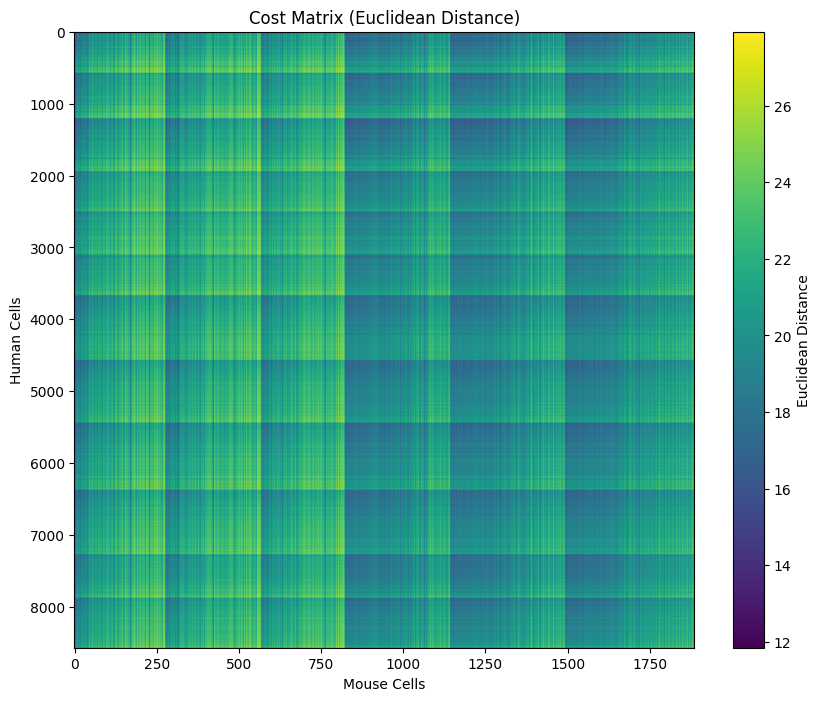

/home/dor3/.local/lib/python3.8/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


8569

In [16]:
paired_indices, ot_matrix = optimal_transport_pairing(combined_adata)
len(paired_indices)

In [17]:
print(paired_indices[0])
print(paired_indices[1])
print(paired_indices[2])

(0, 9066)
(1, 8604)
(2, 9246)


In [18]:
print(paired_indices[:50])

[(0, 9066), (1, 8604), (2, 9246), (3, 10178), (4, 9315), (5, 9196), (6, 9815), (7, 9886), (8, 9161), (9, 10370), (10, 10273), (11, 8953), (12, 8582), (13, 9796), (14, 10147), (15, 9959), (16, 9810), (17, 10375), (18, 9139), (19, 9729), (20, 9815), (21, 9523), (22, 10070), (23, 10077), (24, 9736), (25, 9738), (26, 9759), (27, 8658), (28, 9122), (29, 9541), (30, 8690), (31, 8958), (32, 9714), (33, 9895), (34, 10192), (35, 8604), (36, 9433), (37, 10078), (38, 9421), (39, 9432), (40, 9163), (41, 10078), (42, 10133), (43, 8688), (44, 9163), (45, 9682), (46, 8890), (47, 9114), (48, 9434), (49, 9514)]


## The mouse indices need to be normalized. 
Right now, the paired indices represent the pairings of the human -> mouse cells within the concatted data,
This means that mouse indices begin at human_restricted.n_obs
Instead, we want mouse indices to begin at 0

In [ ]:
# Sanity check! The number of indices should be the same as the number of human cells (because we are transporting human cells)
len(paired_indices) == human_restricted.n_obs

True

In [ ]:
normalized_paired_indices = []
for (h, m) in paired_indices:
    normalized_paired_indices.append((h, m-human_restricted.n_obs))


In [46]:
# Sanity check
max_mouse_index = 0
for (h, m) in normalized_paired_indices:
    if m > max_mouse_index:
        max_mouse_index = m
print(max_mouse_index)

# Sanity check! The max mouse index should be within the valid range of normalized mouse indices
max_mouse_index < mouse_restricted.n_obs

1885


True

## Now that we have validated our normalization of the mouse data, assign normalized data to paired_indices.

In [47]:
paired_indices = normalized_paired_indices

In [48]:
# Create the "plots" directory if it doesn't exist
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


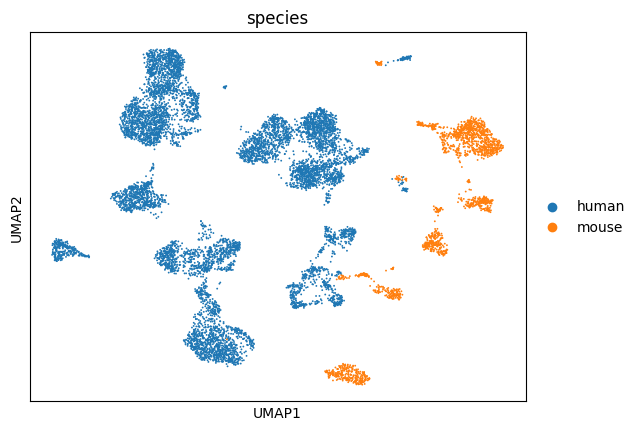

UMAP plot saved to plots/umap_harmonized_homologous_data_colored_by_species.png


In [57]:
# Optional: Visualize the optimal transport pairs on UMAP
# sc.pp.neighbors(combined_adata, use_rep='X_pca')
# sc.tl.umap(combined_adata)

# Visualize UMAP
umap_species_plot_path = os.path.join(plots_dir, "umap_harmonized_homologous_data_colored_by_species.png")
fig = sc.pl.umap(combined_adata, color=['species'], return_fig=True, s=7)
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_species_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_species_plot_path}")


/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


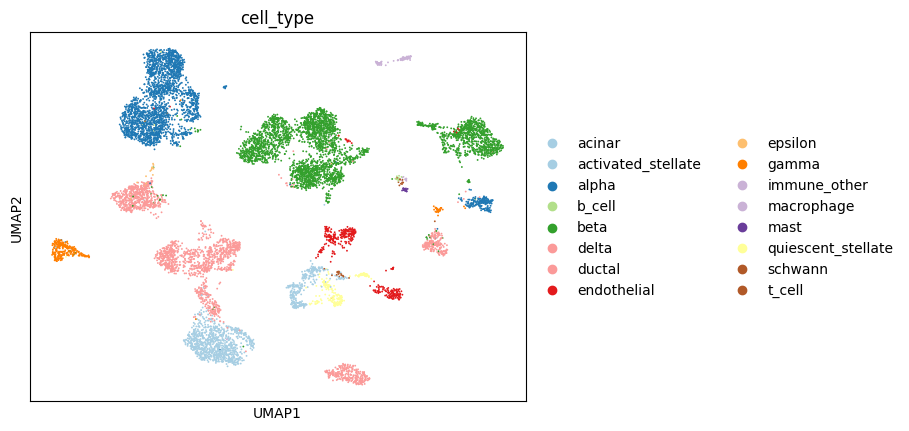

UMAP plot saved to plots/umap_harmonized_homologous_data_colored_by_cell_type.png


In [59]:
# Optional: Visualize the optimal transport pairs on UMAP
# sc.pp.neighbors(combined_adata, use_rep='X_pca')
# sc.tl.umap(combined_adata)

# Visualize UMAP
umap_cell_type_plot_path = os.path.join(plots_dir, "umap_harmonized_homologous_data_colored_by_cell_type.png")
fig = sc.pl.umap(combined_adata, color=['cell_type'], return_fig=True, palette="Paired", s=7)
plt.show()

# Save the plot using matplotlib
fig.savefig(umap_cell_type_plot_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"UMAP plot saved to {umap_cell_type_plot_path}")

# Plot classic OT pairs on umap, showing cell_type and species plots

In [60]:
def plot_joint_umap_with_pairs(
    human_mouse_joint_adata,
    num_human_cells,
    paired_indices,
    color_label,
    save_path,
    title,
    cell_type=None,
    adata_human=None,
    adata_mouse=None,
    filter_by_human=True  # if True, shows which mouse cells all human cells map to, else vice versa
):
    """
    Create a joint UMAP of human and mouse AnnData objects and plot the lines connecting paired cells.

    Parameters:
    - human_mouse_adata: AnnData object for human and mouse cells.
    - paired_indices: List of tuples (human_index, mouse_index) of paired cells.
    - color_label: The column in `obs` to color by.
    - save_path: Path to save the plot.
    - cell_type: (Optional) Filter pairs by specific cell type.
    - adata_human: AnnData object for human cells.
    - adata_mouse: AnnData object for mouse cells.
    - filter_by_human: True to filter by human cell type, False to filter by mouse cell type.
    """
    # Ensure the "plots" directory exists
    plots_dir = os.path.join(os.getcwd(), "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    # Construct the full save path
    full_save_path = os.path.join(plots_dir, save_path)
    
    
    if color_label=='species':
        # Plot the UMAP
        sc.pl.umap(
            human_mouse_joint_adata, 
            color=color_label, 
            show=False, 
            s=7,
            title=title,
        )
    else:
        # Plot the UMAP
        sc.pl.umap(
            human_mouse_joint_adata, 
            color=color_label, 
            show=False, 
            palette="Paired",
            s=7,
            title=title,
        )

    # Extract the UMAP coordinates
    umap_human = human_mouse_joint_adata.obsm['X_umap'][:num_human_cells, :]
    umap_mouse = human_mouse_joint_adata.obsm['X_umap'][num_human_cells:, :]

    # Filter the paired indices based on the specified cell type, if provided
    if cell_type:
        if filter_by_human:
            human_cell_type_mask = adata_human.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if human_cell_type_mask[human_idx]
            ]
        else:
            mouse_cell_type_mask = adata_mouse.obs['cell_types'] == cell_type
            filtered_pairs = [
                (human_idx, mouse_idx) for human_idx, mouse_idx in paired_indices
                if mouse_cell_type_mask[mouse_idx]
            ]
    else:
        # Use all pairs if no cell type is specified
        filtered_pairs = paired_indices

    # Plot lines connecting paired human and mouse cells
    for human_idx, mouse_idx in filtered_pairs:
        # Get the UMAP coordinates of the paired human and mouse cells
        human_coord = umap_human[human_idx]
        mouse_coord = umap_mouse[mouse_idx]
        
        # Plot a light gray line connecting the paired cells
        plt.plot([human_coord[0], mouse_coord[0]], 
                 [human_coord[1], mouse_coord[1]], 
                 color='lightgray', linewidth=0.6, alpha=0.2, linestyle="--")

    # Save the plot
    plt.savefig(full_save_path, facecolor="white", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close()

    # Print confirmation
    print(f"Plot saved to {full_save_path}")

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


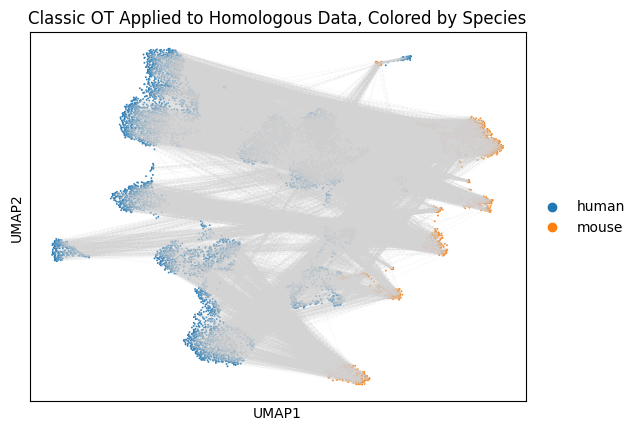

Plot saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Classic_OT_on_Homology_Data/plots/classic_ot_paired_harmonized_homologous_data_species.png


In [61]:
color_label='species'
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=combined_adata, 
    num_human_cells=human_restricted.shape[0],
    paired_indices=paired_indices, 
    color_label=color_label, 
    save_path="classic_ot_paired_harmonized_homologous_data_species.png", 
    title=f"Classic OT Applied to Homologous Data, Colored by {str.capitalize(color_label)}",
    adata_human=human_restricted, 
    adata_mouse=mouse_restricted
)

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


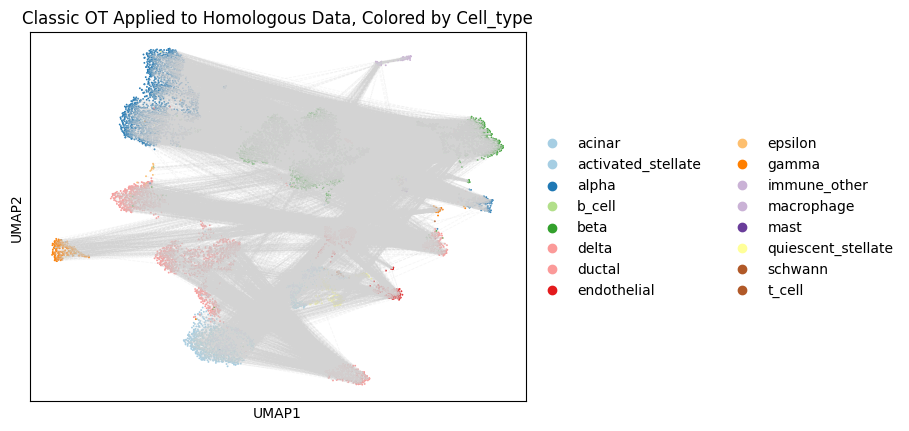

Plot saved to /vast/palmer/home.mccleary/dor3/cell2sentence/cross_species/Classic_OT_on_Homology_Data/plots/classic_ot_paired_harmonized_homologous_data_cell_type.png


In [62]:
color_label='cell_type'
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=combined_adata, 
    num_human_cells=human_restricted.shape[0],
    paired_indices=paired_indices, 
    color_label=color_label, 
    save_path="classic_ot_paired_harmonized_homologous_data_cell_type.png", 
    title=f"Classic OT Applied to Homologous Data, Colored by {str.capitalize(color_label)}",
    adata_human=human_restricted, 
    adata_mouse=mouse_restricted
)

In [63]:
# Extract true labels
human_labels = [x.lower() for x in human_restricted.obs['cell_type'].values]
mouse_labels = [x.lower() for x in mouse_restricted.obs['cell_type'].values]

# Create lists of labels based on paired indices
paired_human_labels = [human_labels[p[0]] for p in paired_indices]
paired_mouse_labels = [mouse_labels[p[1]] for p in paired_indices]

# Ensure both label sets are consistent but separated by species
unique_human_labels = np.unique(human_labels)
unique_mouse_labels = np.unique(mouse_labels)
print("Unique human labels:", unique_human_labels)
print("Unique mouse labels:", unique_mouse_labels)

# Combine unique labels for human and mouse separately
all_labels = np.union1d(unique_human_labels, unique_mouse_labels)

Unique human labels: ['acinar' 'activated_stellate' 'alpha' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'macrophage' 'mast' 'quiescent_stellate'
 'schwann' 't_cell']
Unique mouse labels: ['activated_stellate' 'alpha' 'b_cell' 'beta' 'delta' 'ductal'
 'endothelial' 'gamma' 'immune_other' 'macrophage' 'quiescent_stellate'
 'schwann' 't_cell']


In [64]:
# Reorder all_labels to include common labels first (so our heatmap has a stronger diagonal)
def common_element(list1, list2):
    return [element for element in list1 if element in list2]
common_labels = common_element(unique_human_labels, unique_mouse_labels)
print(common_labels)

for i in all_labels:
    if i not in common_labels:
        common_labels.append(i)

all_labels = common_labels

['activated_stellate', 'alpha', 'beta', 'delta', 'ductal', 'endothelial', 'gamma', 'macrophage', 'quiescent_stellate', 'schwann', 't_cell']


In [65]:
cm_path = "/home/dor3/cell2sentence/cross_species/Classic_OT_on_Homology_Data/plots/classic_ot_homologous_data_confusion_matrix.png"
# Generate confusion matrix with consistent labels
cm = confusion_matrix(paired_human_labels, paired_mouse_labels, labels=all_labels)

# Convert to DataFrame for better visualization
cm_df = DataFrame(cm, index=all_labels, columns=all_labels)

# Compute row and column sums
row_sums = cm_df.sum(axis=1)
col_sums = cm_df.sum(axis=0)
non_zero_rows = row_sums != 0
non_zero_cols = col_sums != 0
filtered_cm_df = cm_df.loc[non_zero_rows, non_zero_cols]
percentage_df = filtered_cm_df.div(filtered_cm_df.sum(axis=1), axis=0) * 100

# Custom annotation function - only show values above threshold
def annot_formatter(val):
    if val > 1:  # Only show values above 1%
        return f'{val:.1f}' if val < 10 else f'{val:.1f}'  # One decimal for small values
    return ''

# Create annotation matrix
annot_matrix = percentage_df.applymap(annot_formatter)

# Create a matplotlib figure and axis
plt.figure(figsize=(12, 10))

# Create custom colormap with better differentiation for small values
cmap = sns.color_palette("Greens", as_cmap=True)

heatmap = sns.heatmap(percentage_df,
            annot=annot_matrix,
            fmt='',
            cmap=cmap,
            linewidths=0.5,
            square=True,  # Make cells square
            cbar_kws={'label': 'Percentage (%)',
                     'shrink': .8},  # Customize colorbar
            annot_kws={'size': 8},  # Adjust annotation font size
            vmin=0,
            vmax=100)  # Fix color scale from 0 to 100%

# Get the colorbar and add gray outline
colorbar = heatmap.collections[0].colorbar
colorbar.outline.set_edgecolor('gray')
colorbar.outline.set_linewidth(0.7)

# Rotate axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add descriptive title and labels
plt.title('Human-Mouse Cell Type Correspondence (%)', 
          pad=20,
          fontsize=16,
          fontweight='bold')

plt.xlabel('Mouse Cell Types', fontsize=15, labelpad=12)
plt.ylabel('Human Cell Types', fontsize=15, labelpad=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot using matplotlib
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory

# Print confirmation
print(f"Enhanced confusion matrix plot saved to {cm_path}")


Enhanced confusion matrix plot saved to /home/dor3/cell2sentence/cross_species/Classic_OT_on_Homology_Data/plots/classic_ot_homologous_data_confusion_matrix.png


# Legacy code below (currently not using code below)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


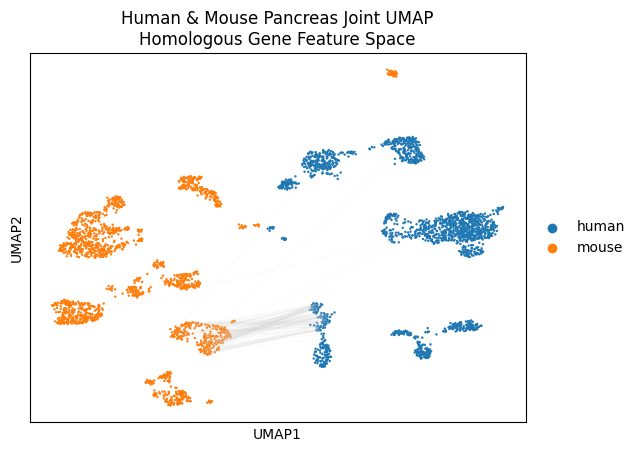

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


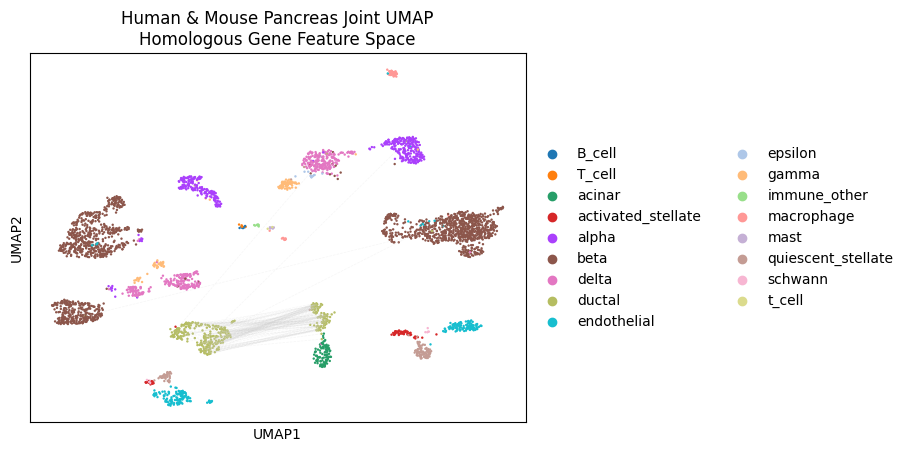

In [18]:
cell_type_label = "ductal"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


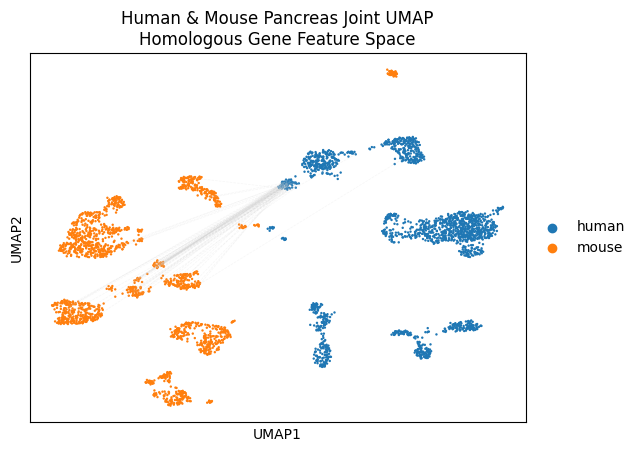

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


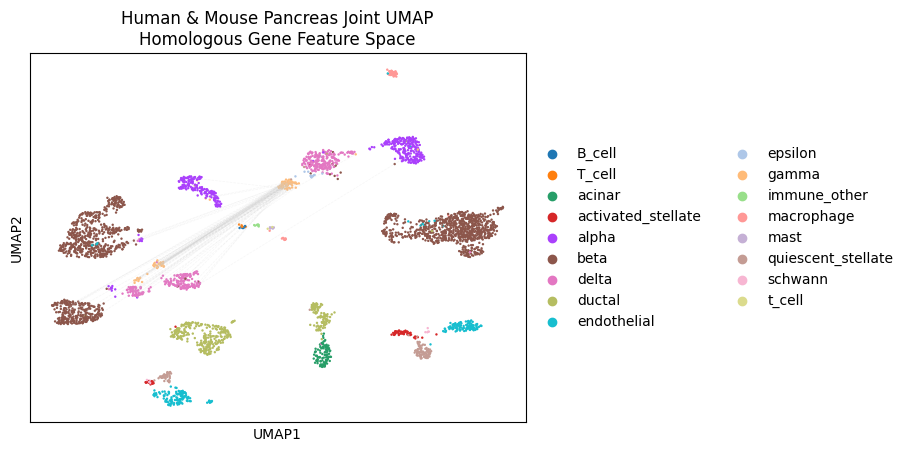

In [19]:
cell_type_label = "gamma"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


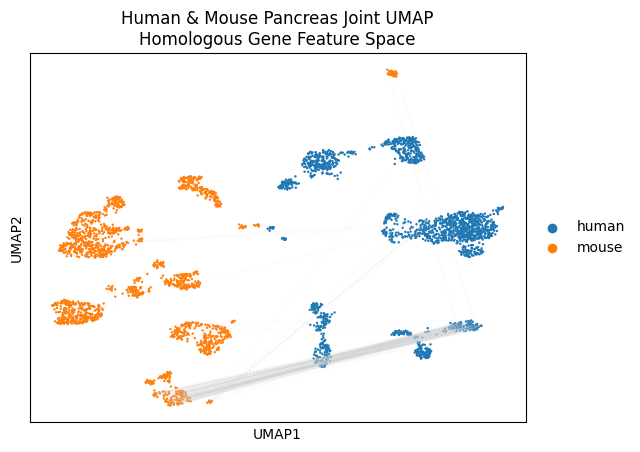

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


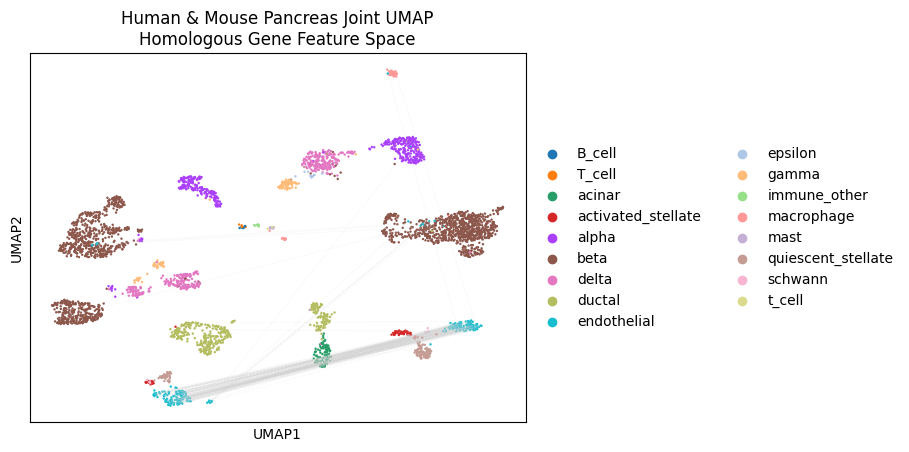

In [20]:
cell_type_label = "endothelial"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


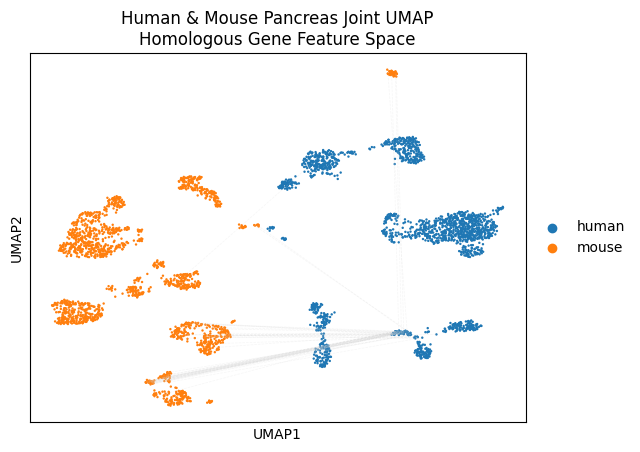

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


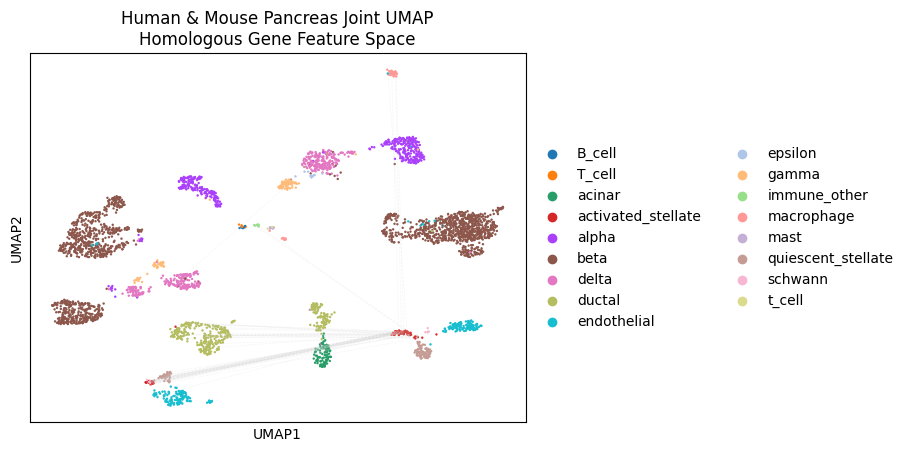

In [21]:
cell_type_label = "activated_stellate"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


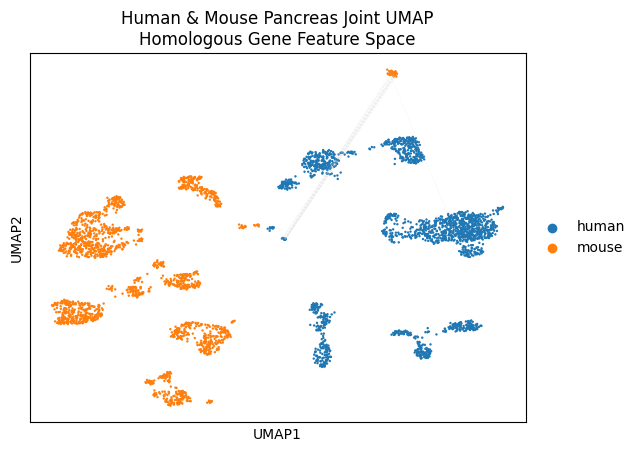

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


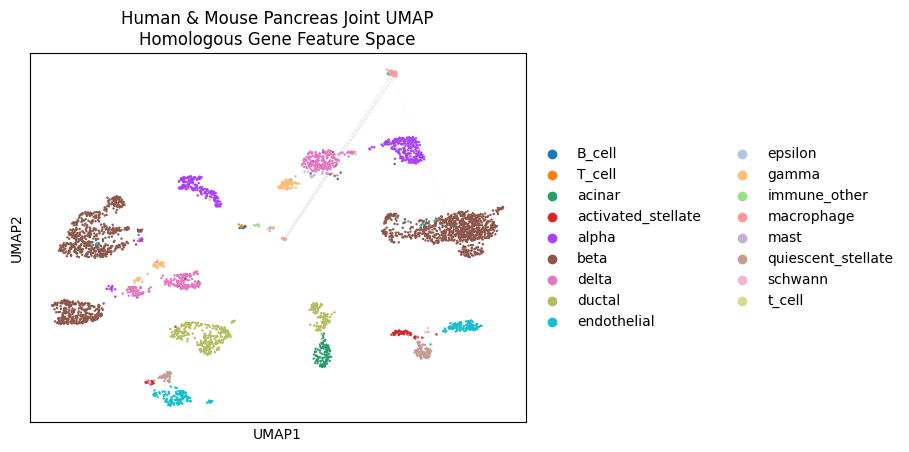

In [22]:
cell_type_label = "macrophage"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


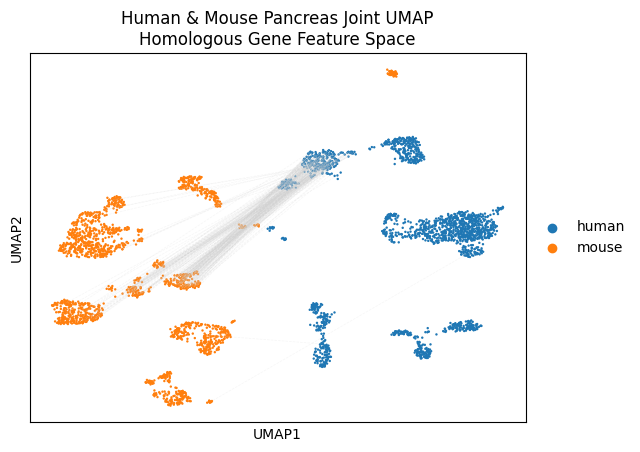

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


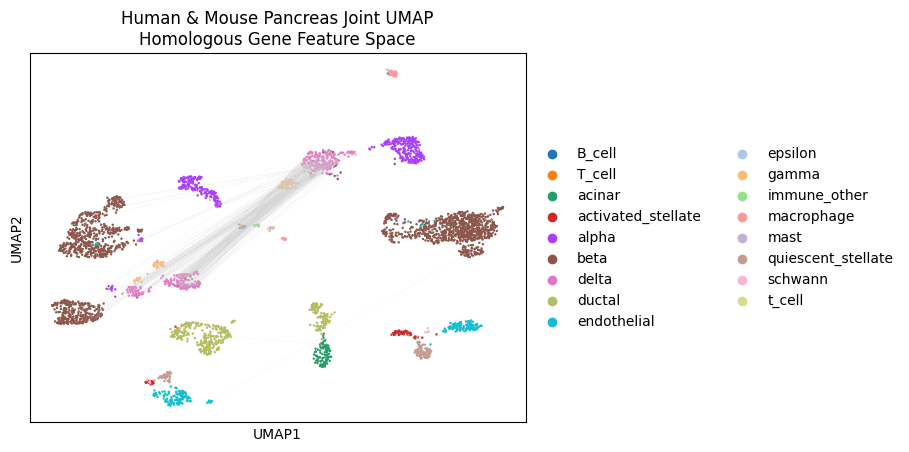

In [23]:
cell_type_label = "delta"
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="species_label",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)
plot_joint_umap_with_pairs(
    human_mouse_joint_adata=human_mouse_adata, 
    num_human_cells=human_restricted.shape[0], 
    paired_indices=paired_indices,
    color_label="cell_types",  # species_label, cell_types
    save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
    cell_type=cell_type_label,
    adata_human=human_restricted,
    adata_mouse=mouse_restricted,
    filter_by_human=human_to_mouse
)

In [24]:
list(set(human_mouse_adata.obs["cell_types"]))

['immune_other',
 'acinar',
 'ductal',
 'delta',
 'quiescent_stellate',
 'T_cell',
 'beta',
 't_cell',
 'alpha',
 'macrophage',
 'schwann',
 'epsilon',
 'activated_stellate',
 'mast',
 'gamma',
 'B_cell',
 'endothelial']

In [25]:
plot_cell_types = [
    't_cell',
    'B_cell',
    'acinar',
    'epsilon',
    'T_cell',
    'mast',
    'schwann',
    'immune_other',
    'quiescent_stellate'
]

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


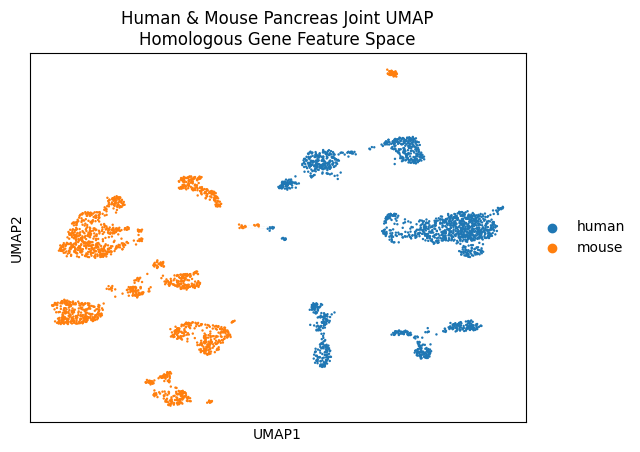

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


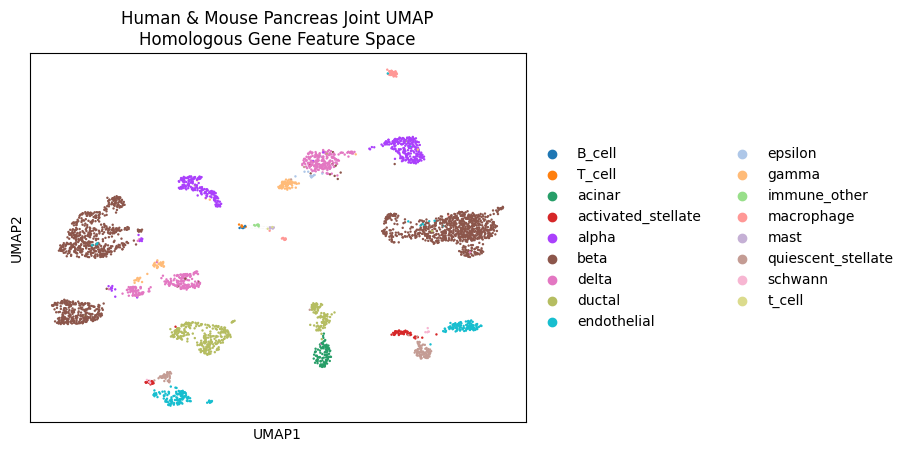

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


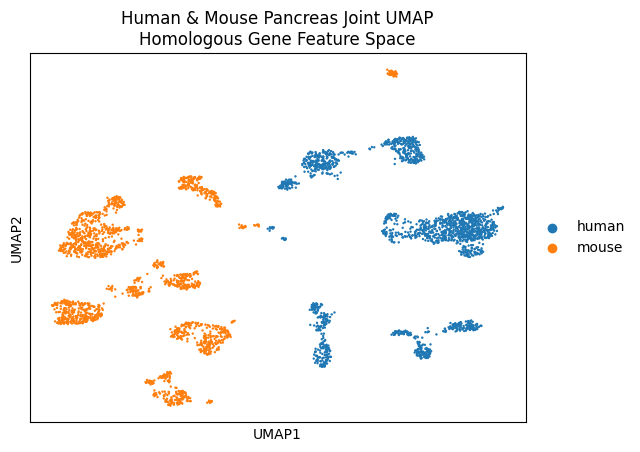

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


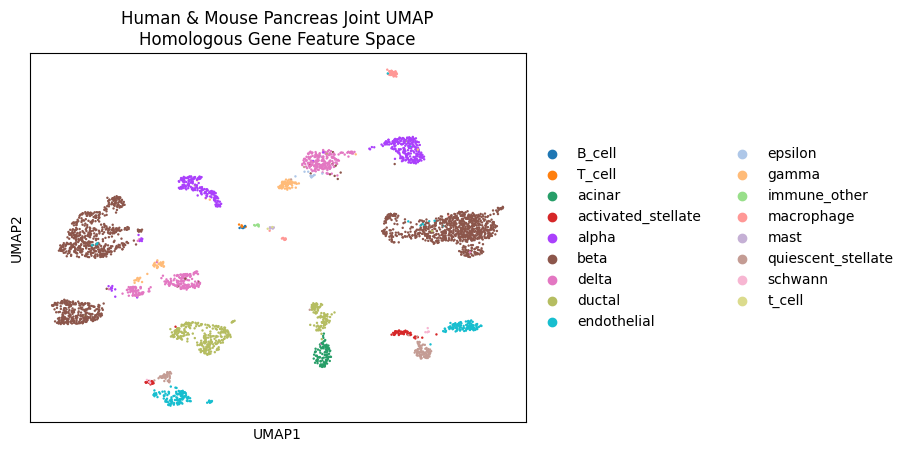

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


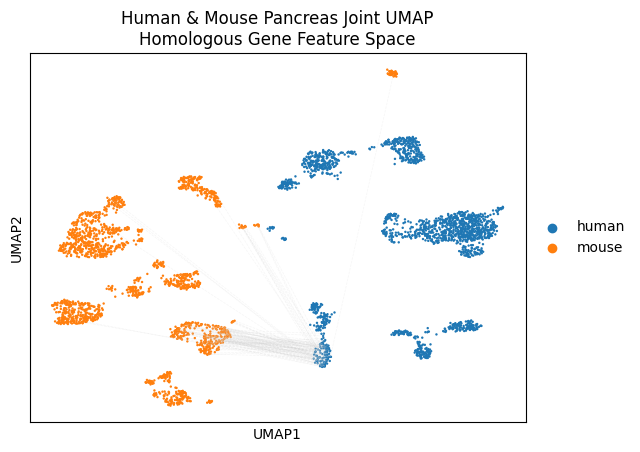

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


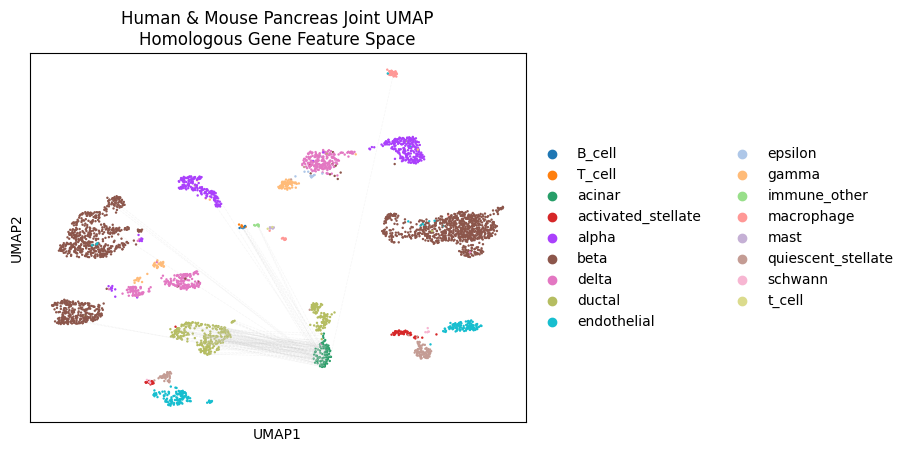

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


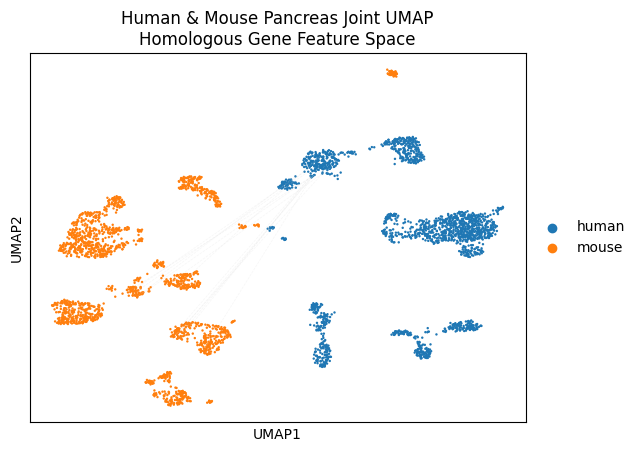

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


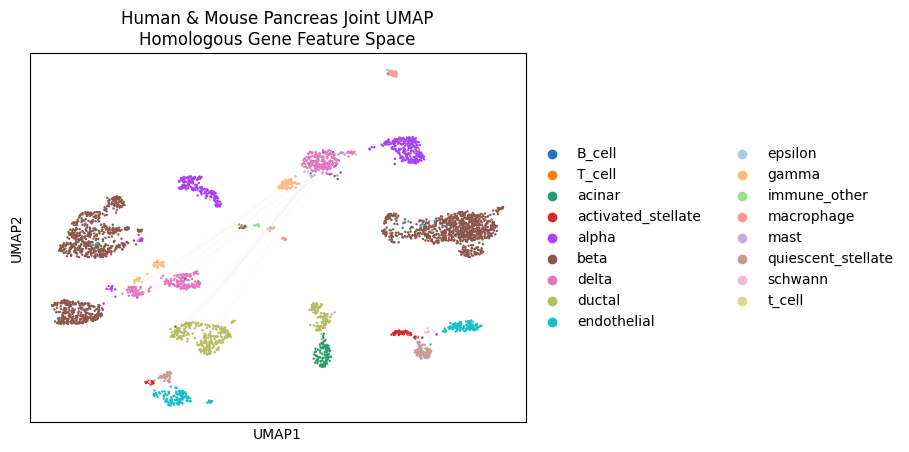

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


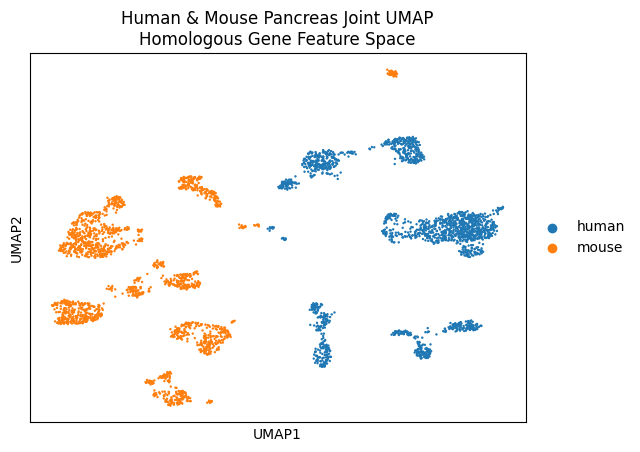

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


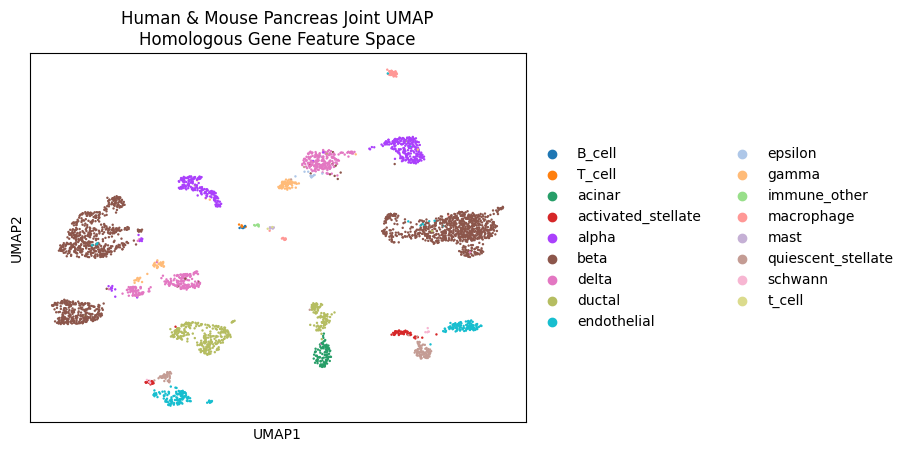

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


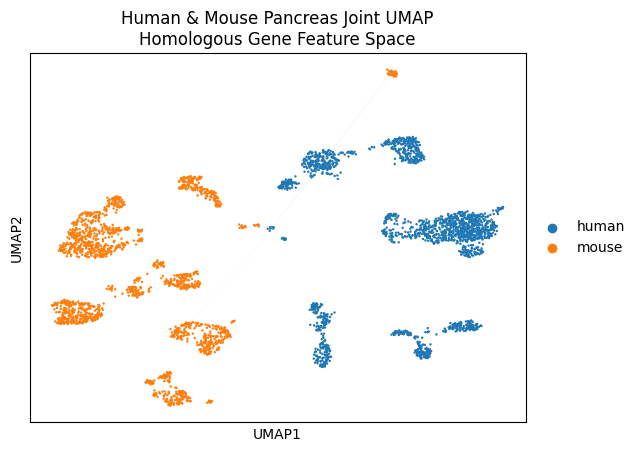

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


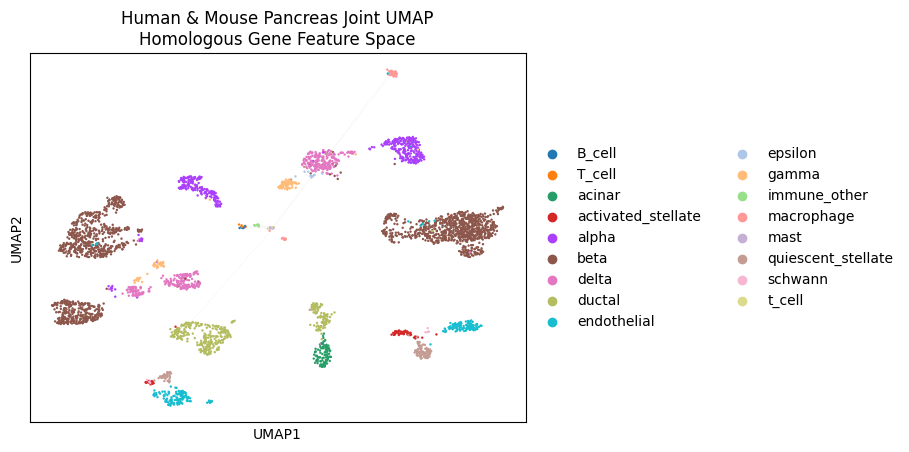

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


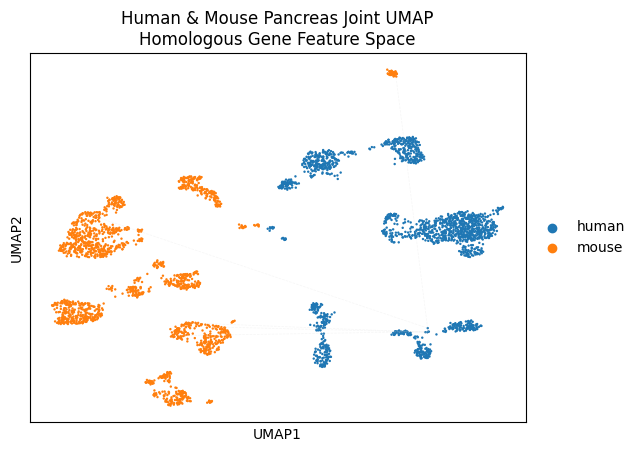

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


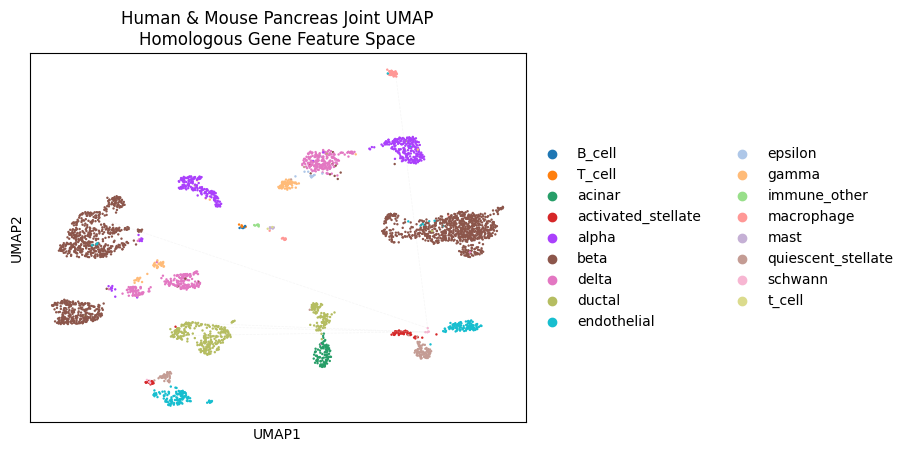

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


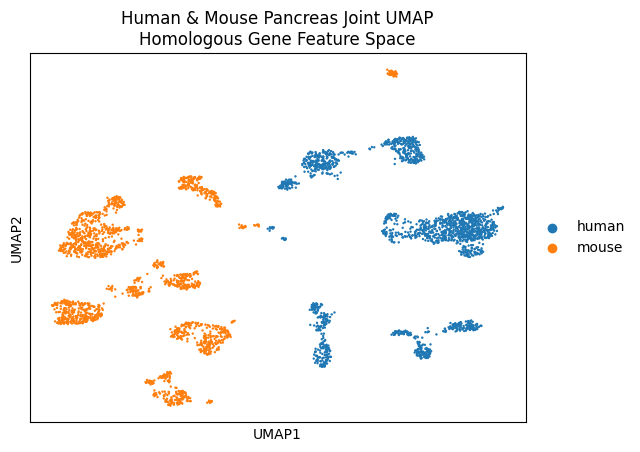

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


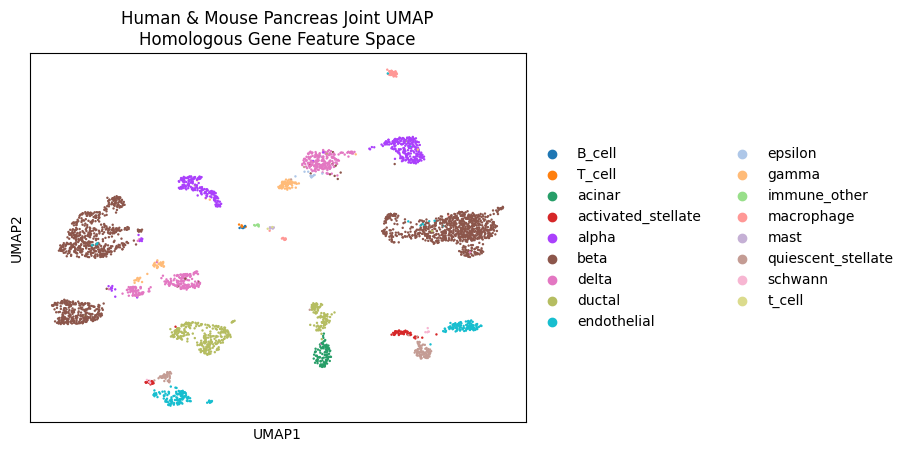

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


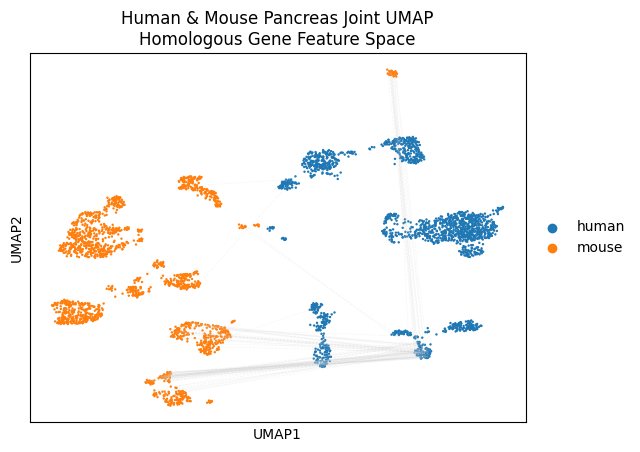

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


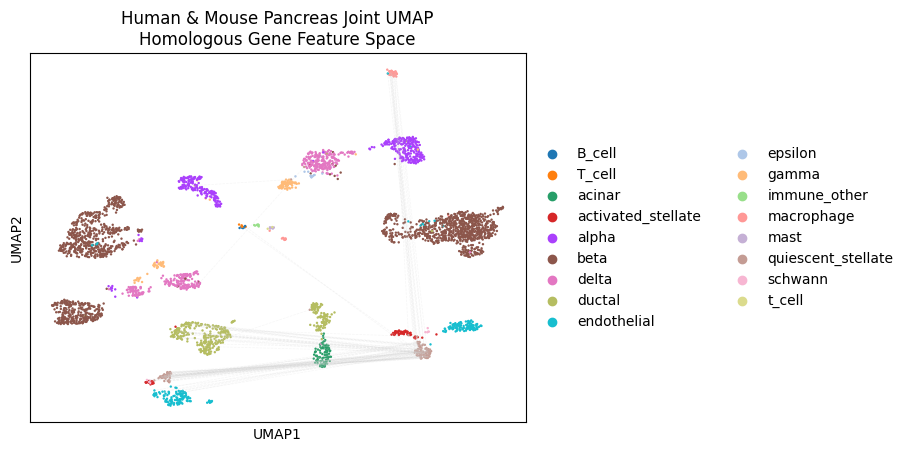

In [26]:
for cell_type_label in plot_cell_types:
    plot_joint_umap_with_pairs(
        human_mouse_joint_adata=human_mouse_adata, 
        num_human_cells=human_restricted.shape[0], 
        paired_indices=paired_indices,
        color_label="species_label",  # species_label, cell_types
        save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_species_{cell_type_label}_{human_to_mouse_str}.png",
        cell_type=cell_type_label,
        adata_human=human_restricted,
        adata_mouse=mouse_restricted,
        filter_by_human=human_to_mouse
    )
    plot_joint_umap_with_pairs(
        human_mouse_joint_adata=human_mouse_adata, 
        num_human_cells=human_restricted.shape[0], 
        paired_indices=paired_indices,
        color_label="cell_types",  # species_label, cell_types
        save_path=f"/home/dor3/palmer_scratch/C2S_Files_Daphne/Cross_Species_Datasets/mouse_human_pancreas_tissue_Baron_et_al/processed_homolog_intersected_data/human_mouse_joint_umap_with_ot_pair_paths_color_cell_type_{cell_type_label}_{human_to_mouse_str}.png",
        cell_type=cell_type_label,
        adata_human=human_restricted,
        adata_mouse=mouse_restricted,
        filter_by_human=human_to_mouse
    )